# Kraken - recognition training

In this notebook I will illustrate how to train HTR models using [Kraken](https://kraken.re). I will focus on ancient Hebrew manuscripts and on various methods of transfer learning. The current notebook will deal with manuscript Geneve 146 (DOI: 10.5076/e-codices-bge-cl0146).




## Setup

### Imports

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import numpy as np
from PIL import Image
from pathlib import Path
import seaborn as sn

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from kraken import blla, binarization, rpred
import kraken
from kraken.lib.dataset import global_align, compute_confusions, preparse_xml_data
from kraken.serialization import render_report

from kraken.lib.train import RecognitionModel, KrakenTrainer
import shutil

from tqdm import tqdm
# from typing import cast, Set, List, IO, Any
import xml.etree.ElementTree as ET


import pandas as pd

### Data 

We define the locations of the data. Since some polygons exported by eScriptorium seem to be malformed (see [this GitHub issue](https://github.com/mittagessen/kraken/issues/259)), we used the script `kraken.contrib.repolygonize` to repolygonize them. The `data` folder contains both the original and the repolygonized XML files. We will run our experiments on the repolygonized dataset.

Images were obtained from the [National Library of Israel's Ktiv database. ](https://web.nli.org.il/sites/NLIS/he/ManuScript/Pages/Item.aspx?ItemID=PNX_MANUSCRIPTS990000415360205171&SearchTxt=%D7%99%D7%9C%D7%A7%D7%95%D7%98%20%D7%93%D7%A8%D7%A9%D7%95%D7%AA%20%D7%95%D7%91%D7%90%D7%95%D7%A8%D7%99%D7%9D%20%D7%A2%D7%9C%20%D7%94%D7%AA%D7%95%D7%A8%D7%94%20%D7%95%D7%94%D7%94%D7%A4%D7%98%D7%A8%D7%95%D7%AA). Credit: מאוסף הספריה הלאומית.
Segmentation and translitteration were provided by Prof Moshe Lavee.

In [2]:
base_path = Path('..') if Path('../data').is_dir() else Path('.')
data_path = base_path / Path('data') / Path('Geneve146_v2')
train_path =  data_path / Path('train')
val_path =   data_path / Path('val')
test_path =   data_path / Path('test') #holdout
outfolder = base_path / "results" / "huntington115"

train_paths = [str(x) for x in train_path.glob('*.xml')]
val_paths = [str(x) for x in val_path.glob('*.xml')]
test_paths = [str(x) for x in test_path.glob('*.xml')]

huntington_115_path = base_path / Path('data') / Path('Huntington115')
huntington_115_paths = [str(x) for x in huntington_115_path.glob('*.xml')]

The model we will be working on:

In [3]:
recognition_models_path = base_path / Path('models') / Path('rec')
base_model_path =  recognition_models_path / Path('biblia_tr_9.mlmodel')

As a sanity check, we check no annotations are in the files (the convention being that `[]` characters are used for additions which do not appear in the manuscript, and `()` for text that appears in the manuscript but should not be). For our purpose we don't want any of these annotation in the data.

In [4]:
#TODO: delete automatically in script somehow
paths = train_paths + val_paths + test_paths
forbidden_characters = ['[', ']', '(', ')']
for p in paths:
    with open(p) as f:
        if any([c in f.read() for c in forbidden_characters]):
            print("WARNING! Forbidden character found in " + Path(p).name)

## Results

### Performance before fine-tuning over Geneve 146

In [5]:
base_model = RecognitionModel(
    model= str(base_model_path),
    training_data=train_paths, 
    evaluation_data=test_paths, 
    format_type='xml', 
    hyper_params = {'augment':False}
    ) 
base_model.setup()
trainer = KrakenTrainer()
trainer.validate(base_model)

Region eSc_dummyblock_ without coordinates
No boundary given for line
Text line "" is empty after transformations
Text line "" is empty after transformations
Text line "" is empty after transformations
Text line "" is empty after transformations
Text line "" is empty after transformations
Text line "" is empty after transformations
Text line "" is empty after transformations
Text line "" is empty after transformations
alphabet mismatch: chars in validation set only: {'/'} (not trained)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Output()

/home/vscode/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.8341301679611206     │
│        val_metric         │    0.8341301679611206     │
└───────────────────────────┴───────────────────────────┘

[{'val_accuracy': 0.8341301679611206, 'val_metric': 0.8341301679611206}]

### Performance before fine-tuning over Huntington 115

This is biased because of diacritics which take accuracy down but why not.
We abuse a dummy model to simply evaluate:

In [6]:
model_dummy_for_test_huntington_115 = RecognitionModel(
    model= str(base_model_path),
    training_data=huntington_115_paths, 
    evaluation_data=huntington_115_paths, 
    format_type='xml', 
    resize = 'both',
    hyper_params = {'augment':False}
    ) 
model_dummy_for_test_huntington_115.setup()
trainer.validate(base_model, dataloaders = model_dummy_for_test_huntington_115.val_dataloader())

Region eSc_dummyblock_ without coordinates
Region eSc_dummyblock_ without coordinates
Text line "" is empty after transformations
Text line "" is empty after transformations
Text line "" is empty after transformations
Text line "" is empty after transformations
Text line "" is empty after transformations
Text line "" is empty after transformations
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.1819915473461151     │
│        val_metric         │    0.1819915473461151     │
└───────────────────────────┴───────────────────────────┘

[{'val_accuracy': 0.1819915473461151, 'val_metric': 0.1819915473461151}]

### Performance after fine-tuning over Geneve 146

A dummy model to efficiently evaluate:

In [7]:
# dummy for test
model_dummy_for_test_geneve146 = RecognitionModel(
    model= str(base_model_path),
    training_data=val_paths, 
    evaluation_data=test_paths, 
    format_type='xml', 
    hyper_params = {'augment':False}
    ) 
model_dummy_for_test_geneve146.setup()

Text line "" is empty after transformations
Text line "" is empty after transformations
alphabet mismatch: chars in validation set only: {'/', 'ץ'} (not trained)


Actual fine-tuning:

In [8]:
model = RecognitionModel(
    model= str(base_model_path),
    training_data=train_paths, 
    evaluation_data=val_paths, 
    format_type='xml', 
    hyper_params = {'augment':False}
    ) 
trainer = KrakenTrainer()

# fine tune
trainer.fit(model)

Region eSc_dummyblock_ without coordinates
No boundary given for line
Text line "" is empty after transformations
Text line "" is empty after transformations
Text line "" is empty after transformations
Text line "" is empty after transformations
Text line "" is empty after transformations
Text line "" is empty after transformations
Text line "" is empty after transformations
Text line "" is empty after transformations
alphabet mismatch: chars in training set only: {'ץ'} (not included in accuracy test during training)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name      ┃ Type                     ┃ Params ┃
┡━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ net       │ MultiParamSequential     │  4.0 M │
│ 1  │ net.C_0   │ ActConv2D                │  1.3 K │
│ 2  │ net.Do_1  │ Dropout                  │      0 │
│ 3  │ net.Mp_2  │ MaxPool                  │      0 │
│ 4  │ net.C_3   │ ActConv2D                │ 40.0 K │
│ 5  │ net.Do_4  │ Dropout                  │      0 │
│ 6  │ net.Mp_5  │ MaxPool                  │      0 │
│ 7  │ net.C_6   │ ActConv2D                │ 55.4 K │
│ 8  │ net.Do_7  │ Dropout                  │      0 │
│ 9  │ net.Mp_8  │ MaxPool                  │      0 │
│ 10 │ net.C_9   │ ActConv2D                │  110 K │
│ 11 │ net.Do_10 │ Dropout                  │      0 │
│ 12 │ net.S_11  │ Reshape                  │      0 │
│ 13 │ net.L_12  │ TransposedSummarizingRNN │  1.9 M │
│ 14 │ net.Do_13 │ Dropout                  │      0 │
│ 15 │ net.L_14  │ TransposedSummarizingRNN │  963 K │
│ 16 │ net.Do_15 │ Dropout                  │      0 │
│ 17 │ net.L_16  │ TransposedSummarizingRNN │  963 K │
│ 18 │ net.Do_17 │ Dropout                  │      0 │
│ 19 │ net.O_18  │ LinSoftmax               │ 30.1 K │
└────┴───────────┴──────────────────────────┴────────┘

Trainable params: 4.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.0 M                                                                                                
Total estimated model params size (MB): 16

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Evaluation:

In [9]:
trainer.validate(model, dataloaders = model_dummy_for_test_geneve146.val_dataloader())

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping


Output()

/home/vscode/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.9323280453681946     │
│        val_metric         │    0.9323280453681946     │
└───────────────────────────┴───────────────────────────┘

[{'val_accuracy': 0.9323280453681946, 'val_metric': 0.9323280453681946}]

### Performance after fine-tuning over Huntington 115

In [10]:
trainer.validate(model, dataloaders = model_dummy_for_test_huntington_115.val_dataloader())

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.1871679574251175     │
│        val_metric         │    0.1871679574251175     │
└───────────────────────────┴───────────────────────────┘

[{'val_accuracy': 0.1871679574251175, 'val_metric': 0.1871679574251175}]

## Export results for human analysis

Helper function to export transliteration:

In [3]:
def kraken_predict(model_fn, xml_paths):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    recognition_model = kraken.lib.train.models.load_any(str(model_fn), device=device)
    res = []
    for path in xml_paths:
        #get segmentation
        test_data = preparse_xml_data([path], format_type='xml')
        seg = {'type' : 'baselines', 'text_direction':'horizontal-rl', 'lines' : []}
        for line in test_data:
            seg['lines'].append(line)
        
        #get image
        img_name = ET.parse(path).getroot().find("{*}Page").get("imageFilename")
        img_dir = Path(path).parent
        img_fn = str(img_dir / img_name)
        im = Image.open(img_fn)
        
        #predict
        pred_it = rpred.rpred(recognition_model, im, seg)
        for record in pred_it:
            t = str(record)
            res.append(t)
    return res

In [12]:
best_model_path = f'model_{model.best_epoch}.mlmodel'
shutil.copy(best_model_path, outfolder / "best_model_geneve146.mlmodel")
res = kraken_predict(best_model_path, huntington_115_paths)

/home/vscode/.local/lib/python3.9/site-packages/kraken/lib/segmentation.py:839: RuntimeWarning: divide by zero encountered in divide
  t1 = np.cross(v, u) / z
/home/vscode/.local/lib/python3.9/site-packages/kraken/lib/segmentation.py:840: RuntimeWarning: divide by zero encountered in divide
  t2 = np.dot(u, w) / z
/home/vscode/.local/lib/python3.9/site-packages/kraken/rpred.py:359: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  pos.append(compute_polygon_section(coords['baseline'],
Region eSc_dummyblock_ without coordinates


In [13]:
res_joined = '\n'.join(res)
print(res_joined)

ﭏ קצאיא מן גיר חוף ותמייל ˙ מבדע ﭏ סמאואת וﭏ ארצין ומורהא
באוצה ﭏ תשכיל ﭏ גאעל פי גמיעהם אתאב חכמתה ﭏתי לא ]
ישובהא תגהיל למא אתת לאמרה חתי וחא טועא ותעגיל כק כי מ'
הוא אמר ויהי וג וקתע אנכי עשיתי ארץ וג' אכתץ תע באוליאי
ושרפהם בﭏ וחי ותנזיל ואנארהם שראעיא מן דון נסך ותבדילו ˙
כל
וצמן להם תואבא אגלא מקתרנא בכראמה ותבגיל ˙ מננים עאדר
עאגלה ואצלהם בהא ﭏגיל בעד גיל כקו ויאנו יוי לעשות את כל
רחקים וג' וחת ﭏחכים שלמה קאילא בני תורתי ﭏ תשכח וג' כי אורך
כי אורך ימים וג' וק איצא שמור מצותי וחיה ˙ וק'ם יירנא דוד
מאדחא אשרי איש ירא וג' וק' פי ﭏ אכתתאחה פקודי יוי ישרים
עבארתה אואמר ﭏלה מסתקימה מפרחה ללקלוב ווציתה נקיה
מנירה ללא באר ˙ אול מא נקולה אן כקודים ומצות ע בארתאן בא
שי ואחד לאן כדלך תרג המצות ﭏין בקודיא וכק פיאול פרשתנא 
את אהרן פקיר יתאהרן וקד עדדנא פי ﭏה פקודי אצול הדה 
לפטה וגמיע ﭏ שריעה ידכל תחת הרא ﭏ אסם ואן באן פיהא א
נואהי לאן ﭏ נהי גיר כארג ען כונה אמרא בתרך ﭏ פעל מא וקע
עליה ﭏ נהי ווצף ﭏ מצות ההנא בר' אוצאף ﭏ אול ישרים כק' כי ישר
דבר יוי וג' ודלך אן ﭏ סמעיאת לא יגוז אן יכון ﭏ עקל

In [14]:
test_data = preparse_xml_data(huntington_115_paths, format_type='xml')
ref = '\n'.join([x['text'] for x in test_data])
print(ref)

Region eSc_dummyblock_ without coordinates


ﭏ קצ̇איא מן גיר חוף ותמייל˙ מבדע ﭏ סמואואת וﭏ ארצ̇ין ומצורהא
באוצ̇ח ﭏ תשכיל  ﭏ ג̇אעל פי ג̇מיעהם אתאר חכמתה ﭏתי לא [ء]
ישובהא תג̇היל למא אתת לאמרה חתי וחא טועא ותעג̇יל כק' כי [ء]
הוא אומר ויהי וג' וק' תע' אנכי עשיתי ארץ וג' אכ̇תץ תע' באוליאיה
ושרפהם בﭏ וחי ו↑תנזיל ואפאדהם שראעיא דון נסך ותבדיל˙
ﭏ
וצ̇מן להם תואבא אג̇לא מקתתא בכראמא ותבג̇דל˙ מע סעאדה
עאג̇לה ואצלהם בהא אג̇יל כקו' ויצונו יוי לעשות את כל
החקים וג' וחת ﭏ חכים שלמה קאילא בני תורתי ﭏ תשכח וג' גי אורך
בי אורך ימים וג' וק' איצ̇א שמור מצותי וחיה˙ וק' סיידנא דוד
מאדחא אשרי אישי ירא וג' יק' פי ﭏ אפתתאחה פקודי יוי ישרים וג'
עבארתה אואמר ﭏלה מסתקימה מפרחה ללקלוב ווציתה נקיה
מנירה ללאבצאר˙ אול מא נקולה אן פקודים ומצות עבארתאן ען
שי ואחד לאן כדלך תרג' המצות אין פקודיא וכק' פי אול פרשתנא צו
את אהרן פקיד ית אהרן˙ וקד עדדנא פי ﭏה פקודי אצול הדה ﭏ
לפט̇ה וג̇מיע ﭏ שריעה ידכל תחת הדא ﭏ אסם ואן כאן פיהא ﭏ
נואהי לאן ﭏנהי גיר כארג̇ ען כונה אמרא בתרך ﭏ פעל מא וקע [ء]
עליה ﭏ נהי ווצף ﭏ מצות ההנא בד' אוצאף ﭏ אול ישרים כק' כי ישר
דבר יוי וג' ודלך אן 

In [15]:
with open(str(outfolder / "huntington_115_ocr.txt"), "w") as f:
    print(res_joined, file = f)
with open(str(outfolder / "huntington_115_gt.txt"), "w") as f:
    print(ref, file = f)

# Better automatic Evaluation over Huntington

We evaluate over pages by the same scribe but from another manuscript ([Bodleian Library MS. Huntington 115](https://digital.bodleian.ox.ac.uk/objects/f1f773bd-4f25-494e-b573-4255a10ad34f/)). The script is the same (Hebrew) but the language is Judeo-Arabic. The results may give some hint if the model is sensitive to language, i.e. if it learnt semantic components of Hebrew or only graphical features.

Helper function to compute CER and WER:

In [103]:
gt = Path("../results/huntington115/huntington_115_gt.txt").read_text()
ocr = Path("../results/huntington115/huntington_115_ocr.txt").read_text()

Preprocessing

In [104]:
okay_letters = "אבגדהוזחטיכךלמםנןסעפףצץקרשת" + "\n" + " " + "ﭏ" + "'" + '"'
def preprocess(txt):
    txt_pp = txt #.replace("ﭏ", "אל")
    txt_pp = "".join(x for x in txt_pp if x in okay_letters)
    txt_pp = txt_pp.split("\n")
    return txt_pp

gt_pp = preprocess(gt)
ocr_pp = preprocess(ocr)

In [105]:
len(gt_pp), len(ocr_pp)

(137, 137)

In [106]:
import jiwer
def compute_word_err(prediction, ground_truth):
    prediction = [x for x in prediction if len(x)>0]
    ground_truth = [x for x in ground_truth if len(x)>0]
    transformation = jiwer.Compose([
        # jiwer.ToLowerCase(),
        jiwer.SubstituteRegexes({"ﭏ": "אל"}),
        jiwer.RemoveWhiteSpace(replace_by_space=True),
        jiwer.RemoveMultipleSpaces(),
        jiwer.RemovePunctuation(),
        jiwer.ReduceToListOfListOfWords(word_delimiter=" ")
    ]) 

    res_wer = jiwer.wer(
        ground_truth, 
        prediction, 
        truth_transform=transformation, 
        hypothesis_transform=transformation
    )

    return res_wer

In [107]:
def compare_texts(prediction, ground_truth, return_confusions=False):
    algn_gt = []
    algn_pred = []
    chars = 0
    error = 0
    words = 0
    word_error = 0
    for x, y in zip(prediction, ground_truth):
        chars += len(y)
        # align and compute character accuracy
        c, algn1, algn2 = global_align(y, x)
        algn_gt.extend(algn1)
        algn_pred.extend(algn2)
        error += c
        # compute word accuracy
        words_gt = ''.join(algn1).split(' ')
        words_pred = ''.join(algn2).split(' ')
        words += len(words_gt)
        if len(y)>0:
            word_error += int(jiwer.wer(y,x)*len(words_gt)) #int() sum([z!=w for z,w in zip(words_gt, words_pred)])
    acc = (chars-error)/chars
    word_acc = (words-word_error)/words
    confusions, scripts, ins, dels, subs = compute_confusions(algn_gt, algn_pred)
    if return_confusions:
        return acc, word_acc, confusions
    return acc, word_acc

char_acc, word_acc = compare_texts(ocr_pp, gt_pp)
100*(1-char_acc) , 100*(1-word_acc)

(7.386204970678579, 25.814536340852136)

In [108]:
compute_word_err(ocr_pp[:80]+ocr_pp[85:], gt_pp[:80]+gt_pp[85:])

0.22236586942469294

Confusion matrix:

In [120]:
def draw_confusion_matrix(mat, characters, prefix):
    df_cm = pd.DataFrame(mat, characters, characters)
    sn.set(font_scale=1) # for label size
    plt.figure(figsize = (10,8))
    s = sn.heatmap(df_cm, annot=True, annot_kws={"size": 7}, fmt='g', norm=LogNorm(), cbar=False) # font size
    s.set(xlabel='Ground Truth', ylabel='HTR')
    # plt.savefig(prefix + '.png', dpi = 600, bbox_inches='tight')
    plt.savefig(prefix + '.eps', dpi = 1200, bbox_inches='tight')
    # plt.savefig(prefix + '.svg', dpi = 1200, bbox_inches='tight')

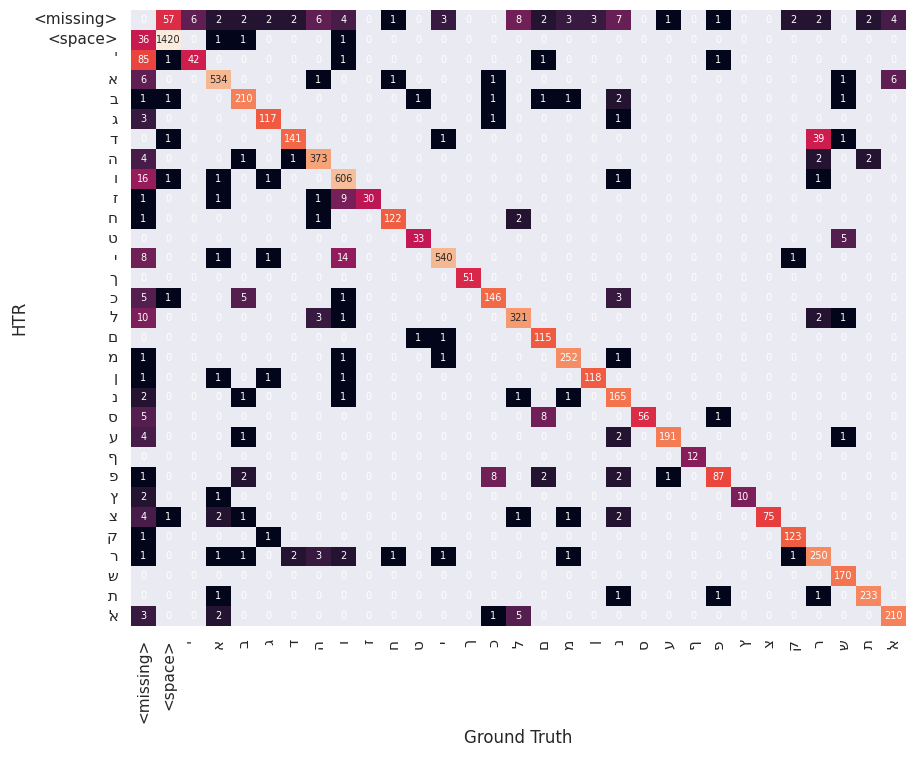

In [121]:
acc, word_acc, confusions = compare_texts(ocr_pp, gt_pp, return_confusions=True)

letters = sorted({k for k,_ in confusions.keys()} | {k for _,k in confusions.keys()})
confusion_matrix = np.array([[confusions[(src,tgt)] for tgt in letters] for src in letters])
letters[0] = "<missing>"
letters[1] = "<space>"
draw_confusion_matrix(confusion_matrix, letters, str(outfolder  / 'confusion_matrix_huntington115'))

Now normalize by GT (columns)

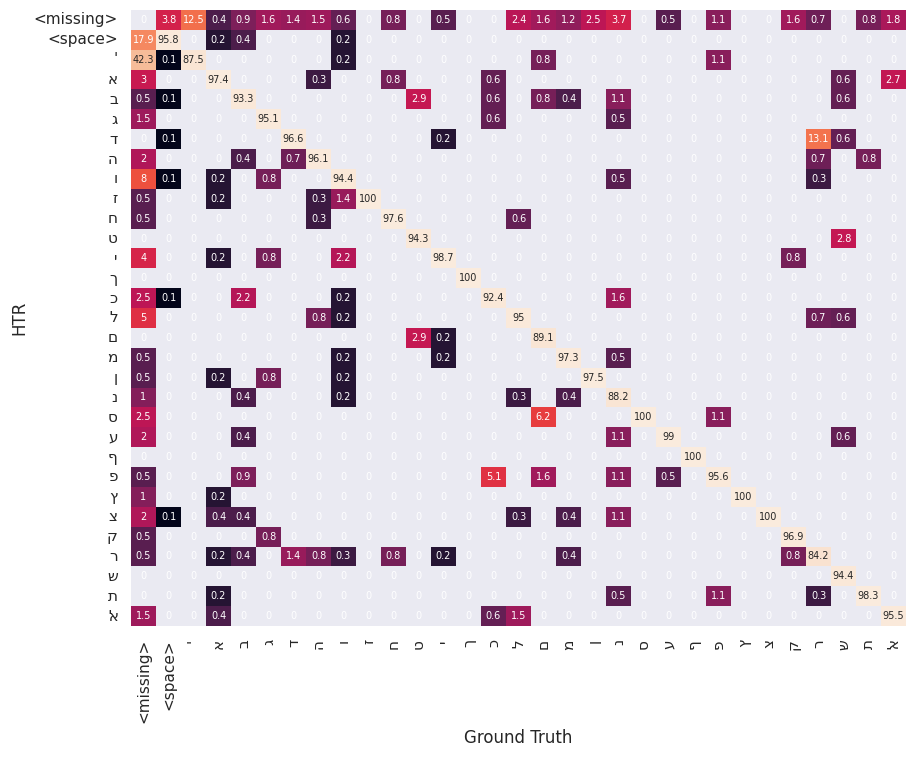

In [122]:
confusion_matrix_norm = confusion_matrix / confusion_matrix.sum(axis=0, keepdims=True)
draw_confusion_matrix(np.round(100*confusion_matrix_norm,1), letters, str(outfolder  / 'confusion_matrix_huntington115_normalized'))

Compute confusion matric on Geneve 146 holdout

In [123]:
geneve146_test_paths = [str(x) for x in test_path.glob('*.xml')]
test_data = preparse_xml_data(geneve146_test_paths, format_type='xml')
gt_geneve146 = [x['text'] for x in test_data] #'\n'.join([x['text'] for x in test_data])
gt_geneve146_pp = gt_geneve146 # preprocess()
ocr_geneve146 = kraken_predict(outfolder / "best_model_geneve146.mlmodel", geneve146_test_paths)
ocr_geneve146_pp = ocr_geneve146 #'\n'.join(ocr_geneve146) #preprocess('\n'.join(ocr_geneve146))

/home/vscode/.local/lib/python3.9/site-packages/kraken/rpred.py:359: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  pos.append(compute_polygon_section(coords['baseline'],
/home/vscode/.local/lib/python3.9/site-packages/kraken/lib/segmentation.py:839: RuntimeWarning: divide by zero encountered in divide
  t1 = np.cross(v, u) / z
/home/vscode/.local/lib/python3.9/site-packages/kraken/lib/segmentation.py:840: RuntimeWarning: divide by zero encountered in divide
  t2 = np.dot(u, w) / z
/home/vscode/.local/lib/python3.9/site-packages/kraken/lib/segmentation.py:839: RuntimeWarning: invalid value encountered in divide
  t1 = np.cross(v, u) / z
/home/vscode/.local/lib/python3.9/site-packages/kraken/lib/segmentation.py:840: RuntimeWarning: invalid value encountered in divide
  t2 = np.dot(u, w) / z
Extracting line failed: No boundary given for line


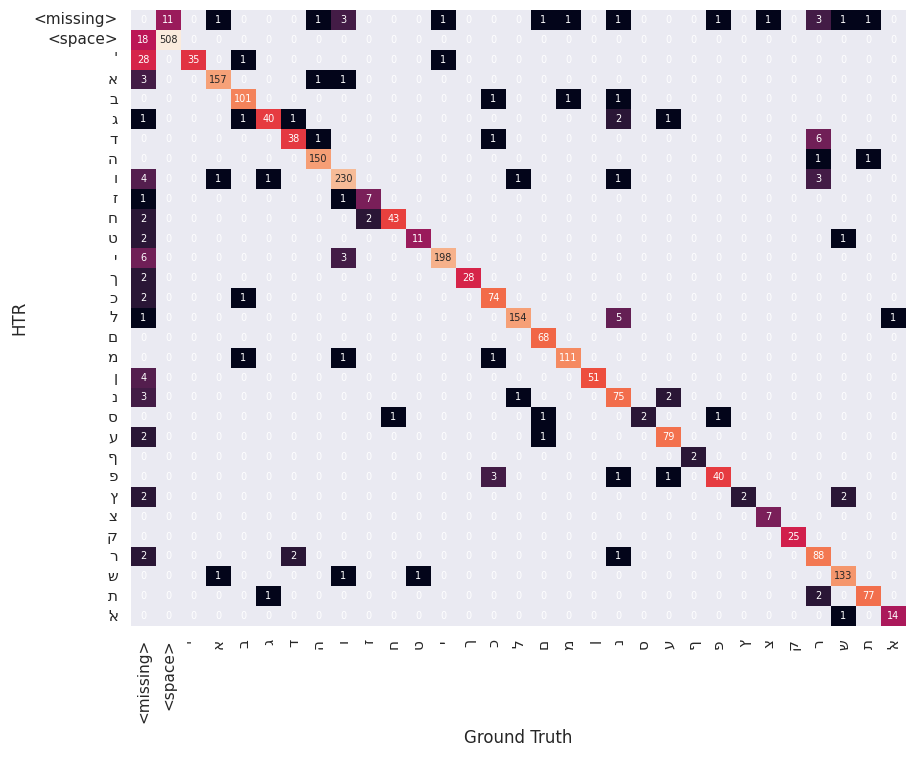

In [124]:
acc, word_acc, confusions_geneve146 = compare_texts(ocr_geneve146, gt_geneve146, return_confusions=True)

letters = sorted({k for k,_ in confusions.keys()} | {k for _,k in confusions.keys()})
letters = [ x for x in letters if x not in  ['/', '˙',] ]
confusion_matrix_geneve146 = np.array([[confusions_geneve146[(src,tgt)] for tgt in letters] for src in letters])
letters[0] = "<missing>"
letters[1] = "<space>"
draw_confusion_matrix(confusion_matrix_geneve146, letters, str(outfolder  / 'confusion_matrix_geneve146'))

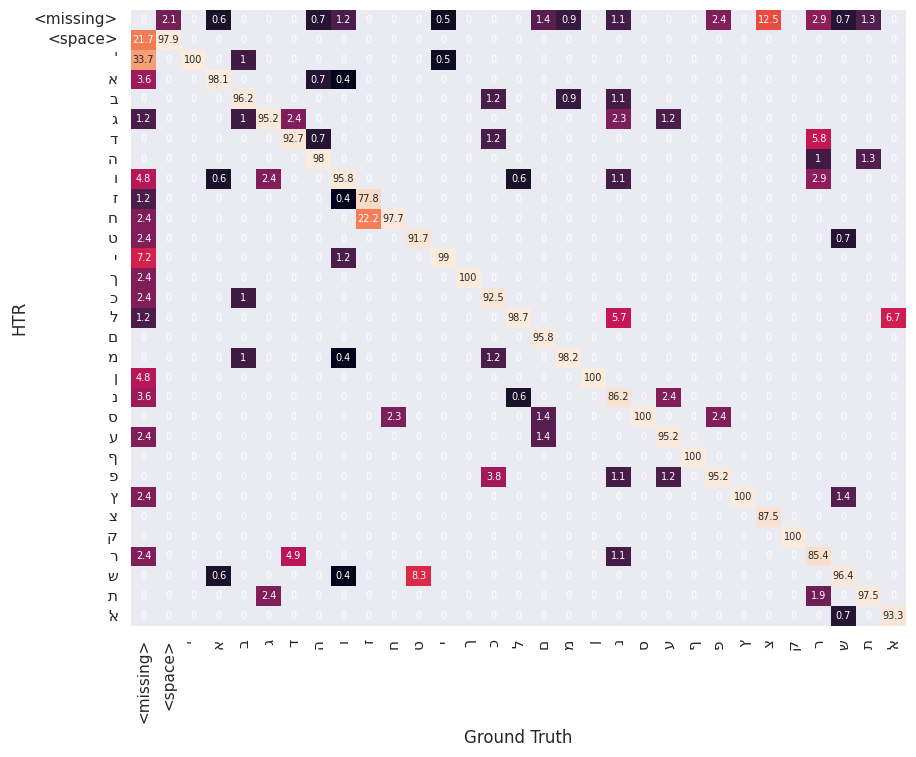

In [125]:
confusion_matrix_norm_geneve146 = confusion_matrix_geneve146 / confusion_matrix_geneve146.sum(axis=0, keepdims=True)
draw_confusion_matrix(np.round(100*confusion_matrix_norm_geneve146,1), letters, str(outfolder  / 'confusion_matrix_geneve146_normalized'))

In [126]:
char_acc, word_acc = compare_texts(ocr_geneve146_pp, gt_geneve146_pp)
100*(1-char_acc) , 100*(1-word_acc)

(6.945975744211685, 24.615384615384617)

In [127]:
compute_word_err(ocr_geneve146_pp, gt_geneve146_pp)

0.22107081174438686

Now display error rate per character

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


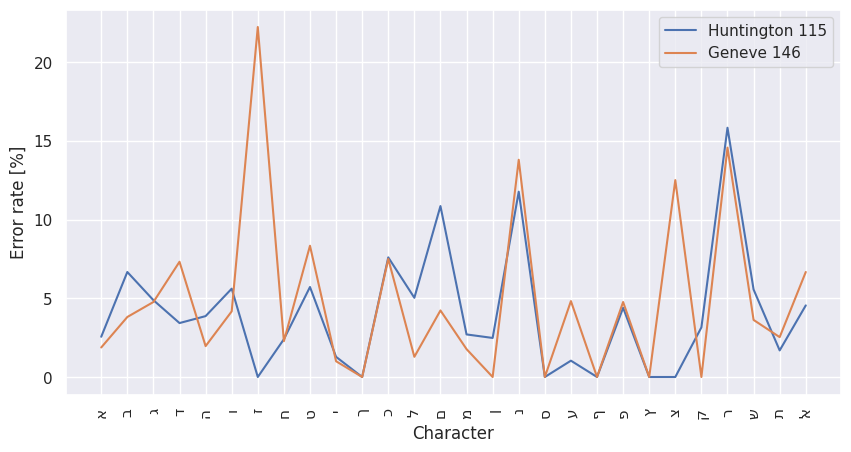

In [128]:
#reduce confusion matrix to error rate per character
def cfm_to_err(cfm):
    cfm = cfm.copy()
    cfm = cfm / cfm.sum(axis=0, keepdims=True)
    error_rates = 100*(1-cfm.diagonal())
    return error_rates

error_rates_huntington115 = cfm_to_err(confusion_matrix)
error_rates_geneve146 = cfm_to_err(confusion_matrix_geneve146)

#plot error rates
plt.figure(figsize=(10,5))
plt.plot(error_rates_huntington115[3:], label='Huntington 115')
plt.plot(error_rates_geneve146[3:], label='Geneve 146')
plt.xticks(range(len(letters[3:])), letters[3:], rotation=90)
plt.ylabel('Error rate [%]')
plt.xlabel('Character')
plt.legend()
plt.savefig(str(outfolder  / 'error_rates.eps'), dpi = 1200, bbox_inches='tight')